In [2]:
import os
import re
import pandas as pd
import csv
import numpy as np
from tqdm import tqdm

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# # Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# # your files will be saved in your Google Drive!

# # the base Google Drive directory
# root_dir = "/content/drive/Shared drives/"

# # choose where you want your project files to be saved
# project_folder = "CESTA Fellows 2023-24/CESTA Events Data/topic_modeling"

# def create_and_set_working_directory(project_folder):
#   # check if your project folder exists. if not, it will be created.
#   if os.path.isdir(root_dir + project_folder) == False:
#     os.mkdir(root_dir + project_folder)
#     print(root_dir + project_folder + ' did not exist but was created.')

#   # change the OS to use your project folder as the working directory
#   os.chdir(root_dir + project_folder)

# create_and_set_working_directory(project_folder)

In [5]:
# get embeddings

In [5]:
df = pd.read_csv('/Users/mervetekgurler/Desktop/PhD/CESTA/cesta-events/data/event_data_with_combined_text.csv')

In [6]:
# this is for getting embeddings on Google Colab with GPU runtime

from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2').to("cuda")

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


encoded_input = tokenizer(
    df["Combined Text"].tolist(),
    padding=True, truncation=True, return_tensors='pt'
).to("cuda")

with torch.no_grad():
    model_output = model(**encoded_input)

embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
embeddings = F.normalize(embeddings, p=2, dim=1).to("cpu").numpy()

# Add embeddings to DataFrame
df["emb"] = list(embeddings)

In [7]:
! pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 M

In [8]:
df.head()

,File Name,Title,Meta Description,H1 Content,Paragraph Content,Date,Location,Combined Text,emb
0,1716323825-1.html,Letterpress Workshop | Center for Spatial and ...,Join us for a 2-hour workshop on letterpress p...,Letterpress Workshop,NaN,"Fri May 17th 2024, 12:30 - 2:30pm",Product Realization Lab (PRL) at D-School,Letterpress Workshop | Center for Spatial and ...,"[-0.008019664, -0.025238251, 0.027148953, -0.0..."
1,1716323825-10.html,Mellon Sawyer Seminar Series: Data of Enslavem...,Enslavement has been the subject of many big d...,Mellon Sawyer Seminar Series: Data of Enslavem...,Enslavement has been the subject of many big d...,"Thu April 25th 2024, 3:00 - 4:30pm","Wallenberg Hall, Room 433A",Mellon Sawyer Seminar Series: Data of Enslavem...,"[-0.026896952, -0.019186044, -0.02210318, 0.03..."
2,1716323825-100.html,"Mark Algee-Hewitt: ""Re-Formations: Visualizing...",About this Talk: The eighteenth century was a ...,"Mark Algee-Hewitt: ""Re-Formations: Visualizing...",About this Talk: The eighteenth century was a ...,"Tue April 19th 2022, 12:00 - 1:15pm",Hybrid event: in-person at CESTA and via Zoom.,"Mark Algee-Hewitt: ""Re-Formations: Visualizing...","[0.01239413, -0.038167957, -0.037837982, -0.05..."
3,1716323825-101.html,"Felicia Smith, Nicole Coleman, Gabriela Basel,...",Note: this seminar will be a hybrid event. We ...,"Felicia Smith, Nicole Coleman, Gabriela Basel,...",Note: this seminar will be a hybrid event. We ...,"Tue April 12th 2022, 12:00 - 1:15pm",Hybrid event: in-person at CESTA and via Zoom.,"Felicia Smith, Nicole Coleman, Gabriela Basel,...","[0.013019499, -0.01871448, -0.041078452, 0.042..."
4,1716323825-102.html,"Grant Parker: ""Curating Enslaved Pasts of the ...",Speaker: Prof. Grant Parker (Stanford) Chair: ...,"Grant Parker: ""Curating Enslaved Pasts of the ...",About this talk: Our project seeks new ways of...,"Thu April 7th 2022, 9:00 - 10:00am",Online via Zoom,"Grant Parker: ""Curating Enslaved Pasts of the ...","[-0.08518801, 0.053646132, -0.034756277, -0.02..."


In [12]:
texts = df["Combined Text"].tolist()

In [15]:
print(type(embeddings))

<class 'numpy.ndarray'>


In [47]:
from umap import UMAP

umap_model = UMAP(n_neighbors=5, n_components=20, min_dist=0.0, metric='cosine', random_state=42)

#Adjust UMAP n_components: Increasing n_components can help discover more topics.

In [49]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

#Adjust HDBSCAN min_cluster_size: Given your dataset size, setting min_cluster_size to 150 might be too high. Reducing it can help create more clusters.

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, max_df=0.95, ngram_range=(1, 3))

#min_df: has to appear at least in n doc
#max_df: ignore word if it appears in more than n of docs

In [ ]:
#embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [50]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Pipeline models
  embedding_model=model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  #representation_model=representation_model,

  # Hyperparameters
  top_n_words=20,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(texts, embeddings)

# Show topics
topic_model.get_topic_info()


2024-06-03 16:38:59,539 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-03 16:39:01,966 - BERTopic - Dimensionality - Completed ✓
2024-06-03 16:39:01,968 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-03 16:39:01,994 - BERTopic - Cluster - Completed ✓
2024-06-03 16:39:02,000 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-03 16:39:02,292 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,52,-1_digital_information_research_university,"[digital, information, research, university, d...","[Cynthia Bennett : ""Centering People in Inform..."
1,0,67,0_cesta_humanities_digital_digital humanities,"[cesta, humanities, digital, digital humanitie...",[Final Presentation Showcase for the Summer 20...
2,1,32,1_history_modern_century_digital,"[history, modern, century, digital, project, e...","[Climbing Snowy Aetna: antiquity, travel, and ..."
3,2,26,2_history_american_data_university,"[history, american, data, university, humaniti...",[Mellon Sawyer Seminar Series: Recuperating Fo...
4,3,24,3_python_workshop_sign_registration,"[python, workshop, sign, registration, learnin...",[Carpentries @ Stanford - Python Introduction ...
5,4,22,4_data_linked_research_pasts,"[data, linked, research, pasts, racism, librar...","[Linked Pasts III: New Voices, Old Places | Ce..."
6,5,21,5_medieval_manuscripts_medieval manuscripts_ma...,"[medieval, manuscripts, medieval manuscripts, ...","[CESTA Seminar Series with Dr. Rowan Dorin, Th..."
7,6,18,6_humanities_digital_women_women gender,"[humanities, digital, women, women gender, dig...",[Women and Gender Minorities in Digital Humani...
8,7,17,7_maps_map_london_jenkins,"[maps, map, london, jenkins, roy, sets, steine...",[CESTA Seminar Series with Mateusz Fafinski | ...
9,8,16,8_land_rio_caribbean_urban,"[land, rio, caribbean, urban, political, studi...",[DHAsia Presents | Moveable Feasts: Street Foo...


In [60]:
topic_model.get_topic(12, full=True)

{'Main': [('eighteenth', 0.03711975214383322),
  ('eighteenth century', 0.03356455780045544),
  ('century', 0.03224878826821355),
  ('algee', 0.02749309796889403),
  ('literary', 0.026258878721263437),
  ('aesthetic', 0.024596383630910965),
  ('hewitt', 0.02425697213967465),
  ('algee hewitt', 0.02425697213967465),
  ('distant', 0.023719379557490806),
  ('reading', 0.02306749506430558),
  ('theory', 0.02088001605008042),
  ('distant reading', 0.020667654724123977),
  ('social', 0.020568667367991036),
  ('history', 0.01958961507622845),
  ('mark algee', 0.018606271308679867),
  ('early', 0.01846508355133798),
  ('germany', 0.018172470452749053),
  ('tell', 0.017465372129308356),
  ('aesthetic theory', 0.0172902453045008),
  ('mark', 0.016418431419592042)]}

In [53]:
topic_model.save("topic_model_v1", save_embedding_model=True)

2024-06-03 16:41:17,067 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [2]:
from bertopic import BERTopic
topic_model = BERTopic.load("/Users/mervetekgurler/Desktop/PhD/CESTA/cesta-events/data/topic_model_v1")

#this is not running because of GPU related save issue

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [61]:
topic_model.visualize_topics()

In [63]:
titles = df['Title'].tolist()

In [64]:
topic_model.visualize_documents(titles, custom_labels=True)

In [65]:
topic_model.visualize_hierarchy()

In [67]:
# `topic_distr` contains the distribution of topics in each document
topic_distr, _ = topic_model.approximate_distribution(texts, window=8, stride=4)

100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


In [68]:
# Visualize the topic-document distribution for a single document
topic_model.visualize_distribution(topic_distr[1], custom_labels=True)

In [69]:
# Extract year from Date column
df['Year'] = df['Date'].apply(lambda x: re.search(r'\d{4}', x).group() if pd.notnull(x) else None)

# Display the dataframe with the new Year column
print(df[['Date', 'Year']])

                                    Date  Year
0      Fri May 17th 2024, 12:30 - 2:30pm  2024
1     Thu April 25th 2024, 3:00 - 4:30pm  2024
2    Tue April 19th 2022, 12:00 - 1:15pm  2022
3    Tue April 12th 2022, 12:00 - 1:15pm  2022
4     Thu April 7th 2022, 9:00 - 10:00am  2022
..                                   ...   ...
402     Thu May 5th 2022, 9:00 - 10:00am  2022
403      Tue May 3rd 2022, 1:00 - 2:15pm  2022
404      Tue May 3rd 2022, 1:00 - 2:15pm  2022
405  Tue April 26th 2022, 12:00 - 1:15pm  2022
406          Thu April 21st 2022, 9:00am  2022

[407 rows x 2 columns]


In [70]:
classes = df['Year'].tolist()

In [71]:
topics_per_class = topic_model.topics_per_class(texts, classes=classes)

9it [00:01,  8.02it/s]


In [72]:
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=50)

In [73]:
topic_model.visualize_heatmap()

In [75]:
topics_over_time = topic_model.topics_over_time(texts, classes)

9it [00:00,  9.46it/s]


In [77]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[0,1,2,3,4,5])

In [78]:
topic_model.visualize_barchart()

In [79]:
df_topic_models = topic_model.get_topic_info()

In [80]:
df_topic_models.to_csv("topic_models_v1.csv")

In [81]:
# wordclouds

def create_oval_mask(width, height, center=None, axes=None):
    if center is None: # use the middle of the image
        center = (int(width / 2), int(height / 2))
    if axes is None: # size of axes
        axes = (int(width / 2), int(height / 2))

    y, x = np.ogrid[:height, :width]
    mask = (((x - center[0]) / axes[0]) ** 2 + ((y - center[1]) / axes[1]) ** 2) > 1
    return 255 * mask.astype(int)

# Create an oval mask
width, height = 1000, 500
mask = create_oval_mask(width, height)

<ipython-input-82-c3eaf1408e95>:34: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



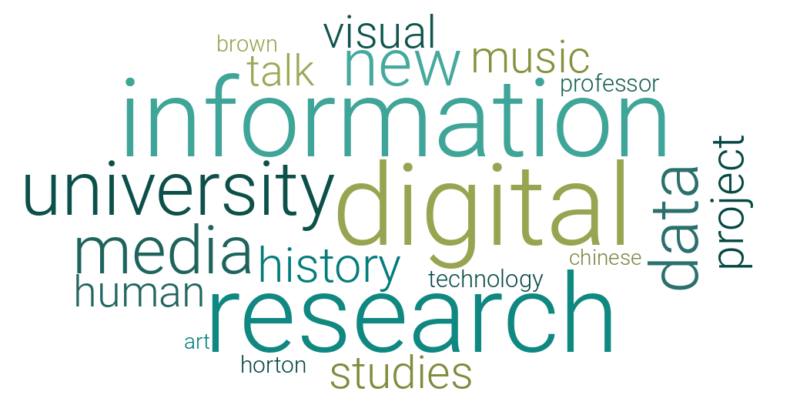

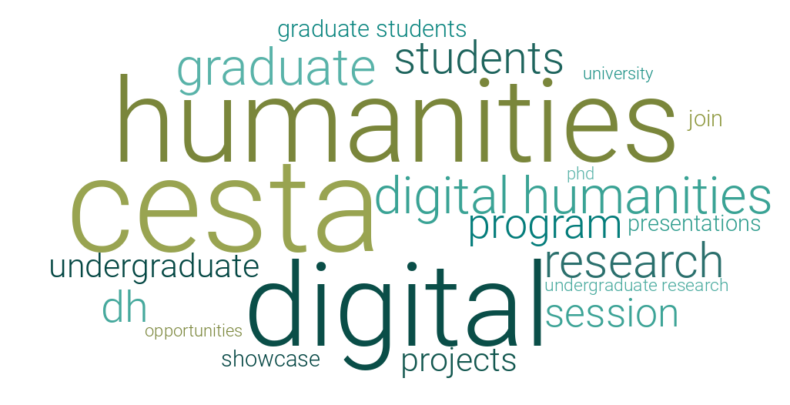

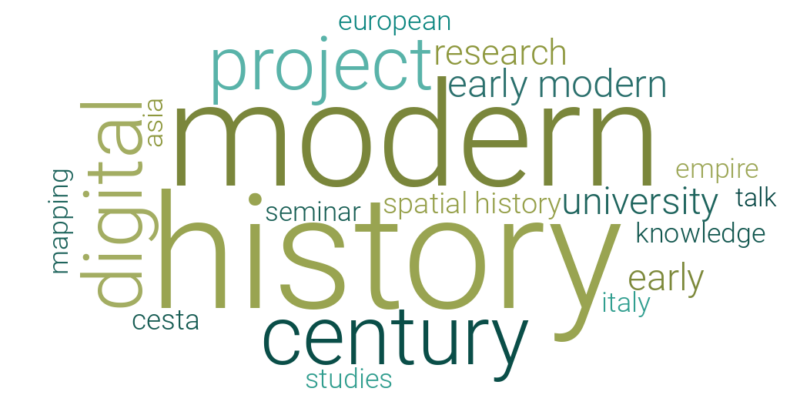

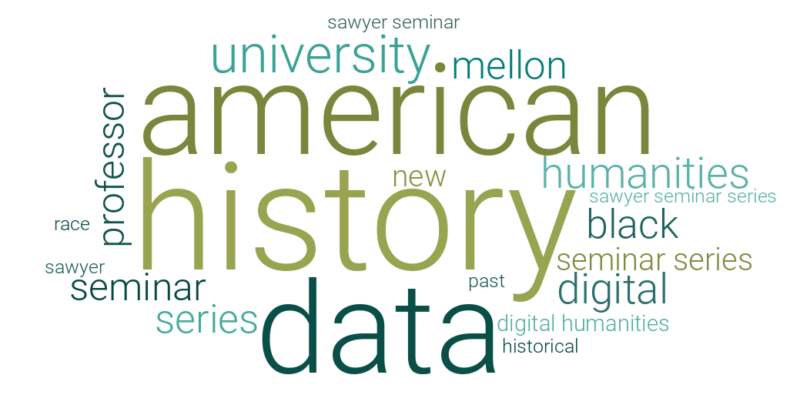

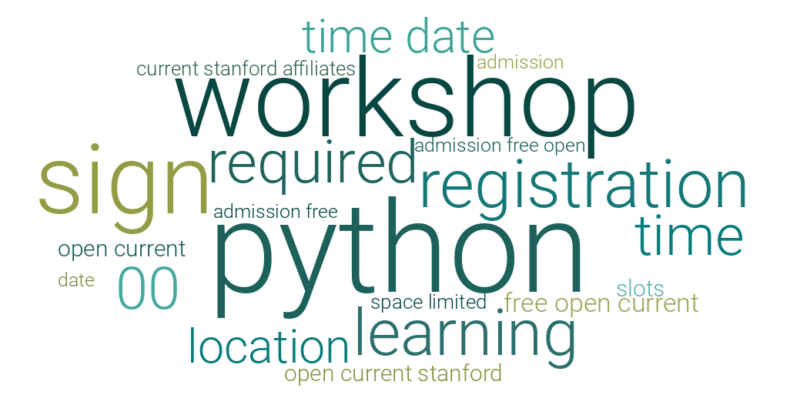

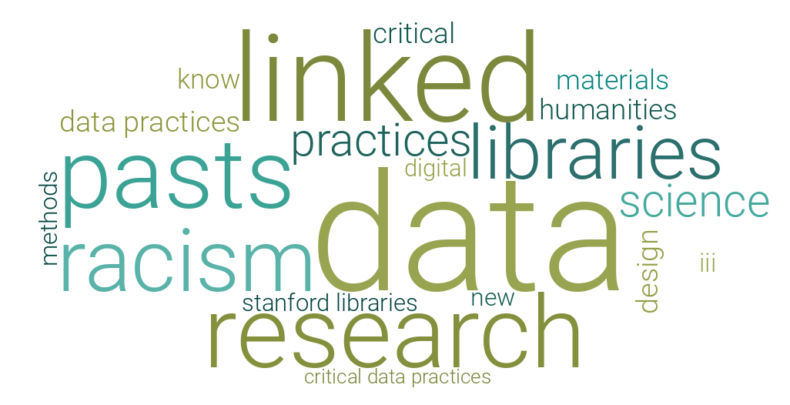

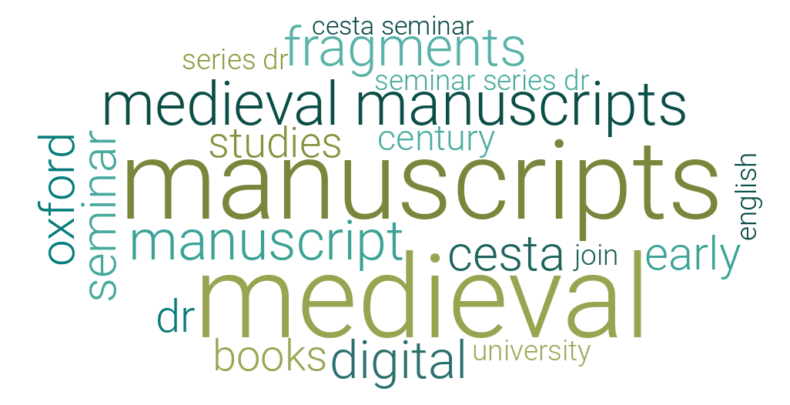

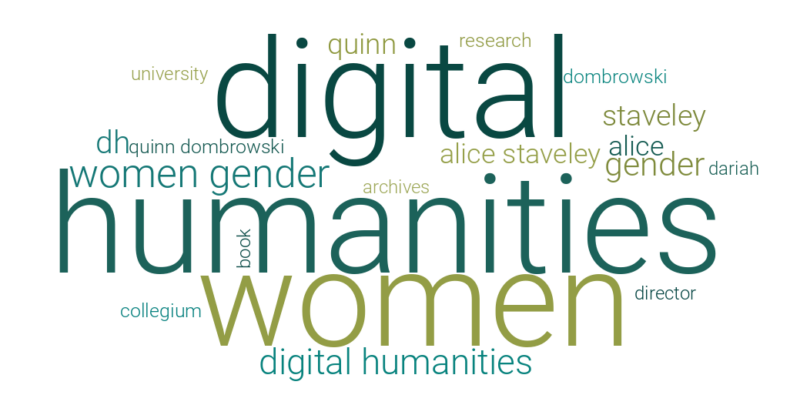

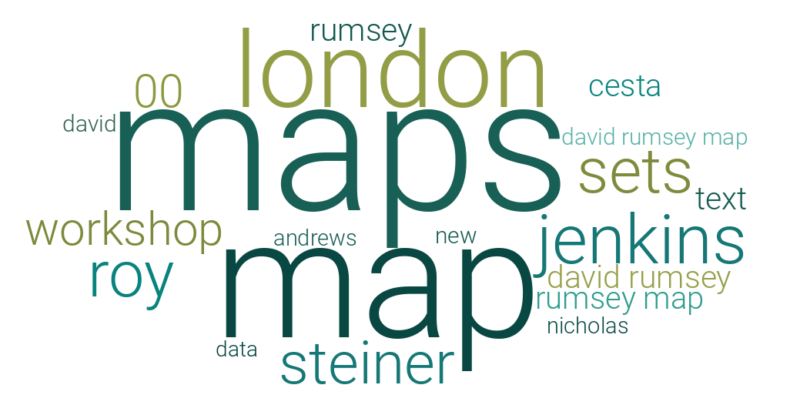

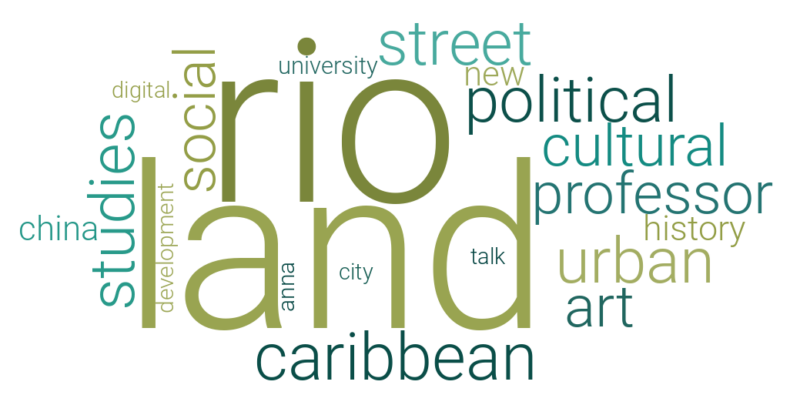

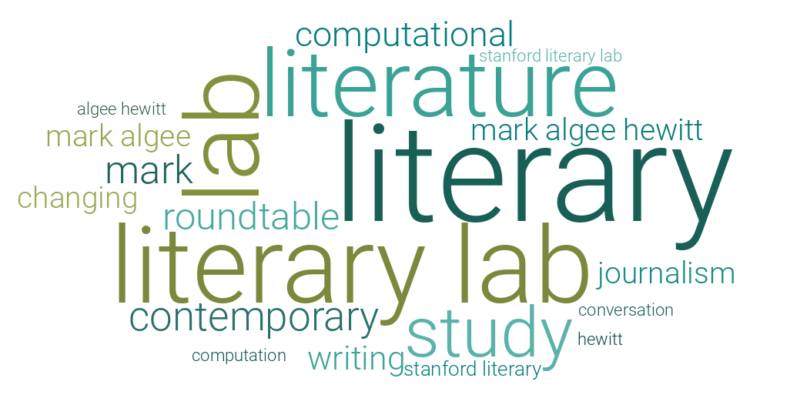

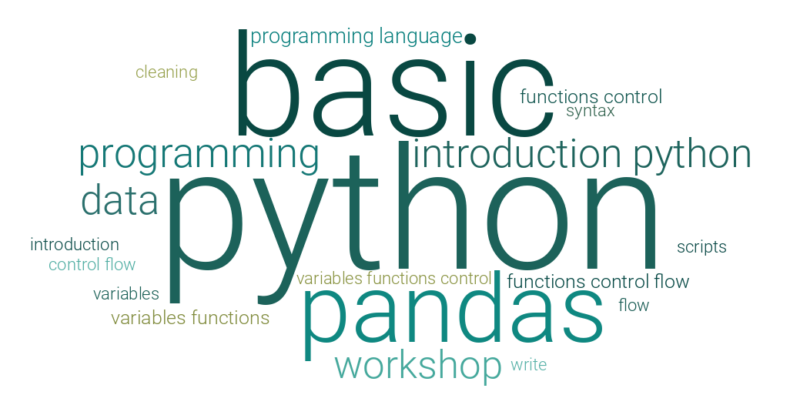

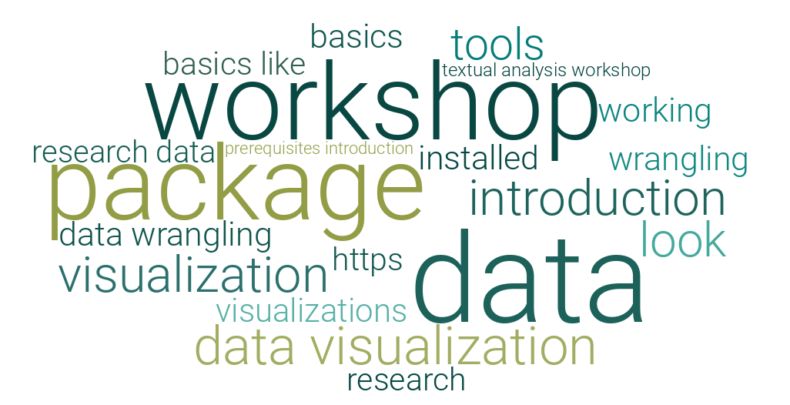

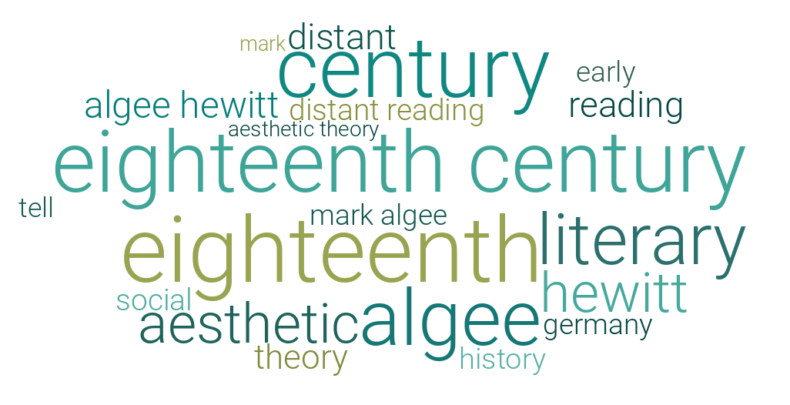

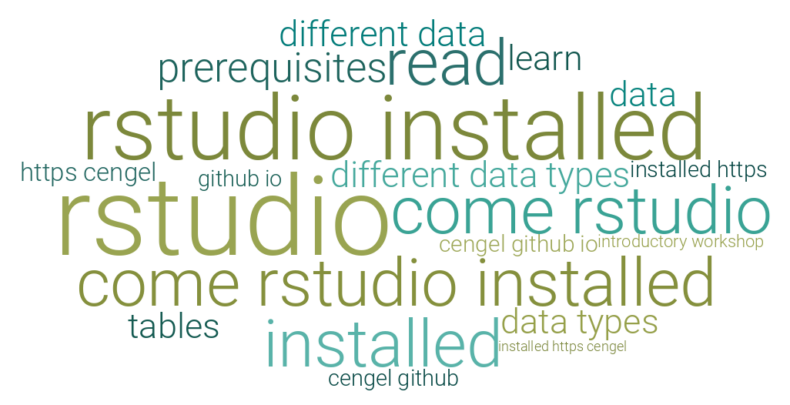

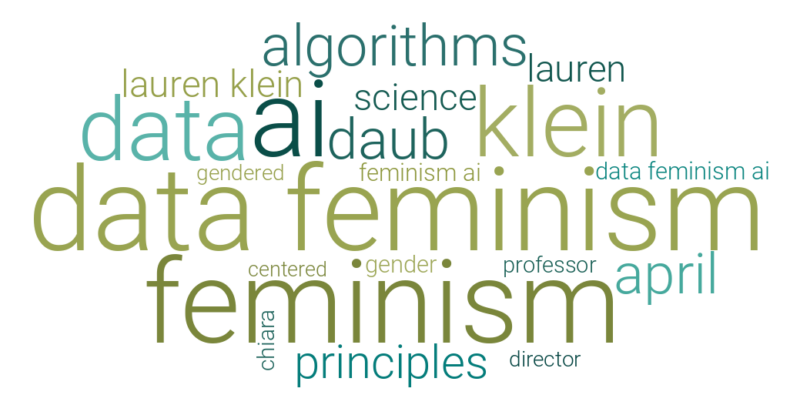

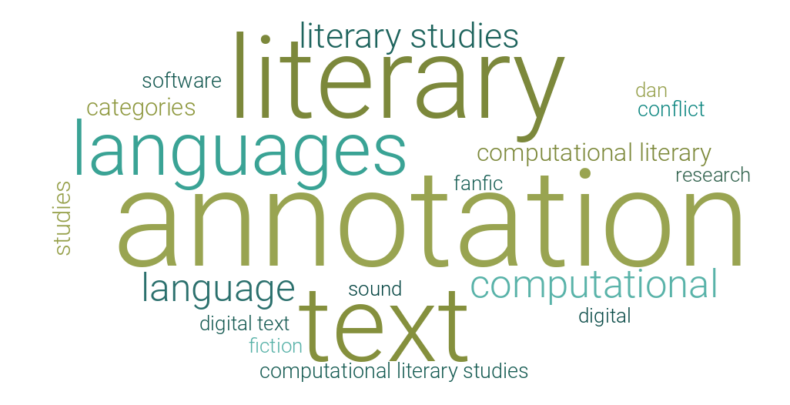

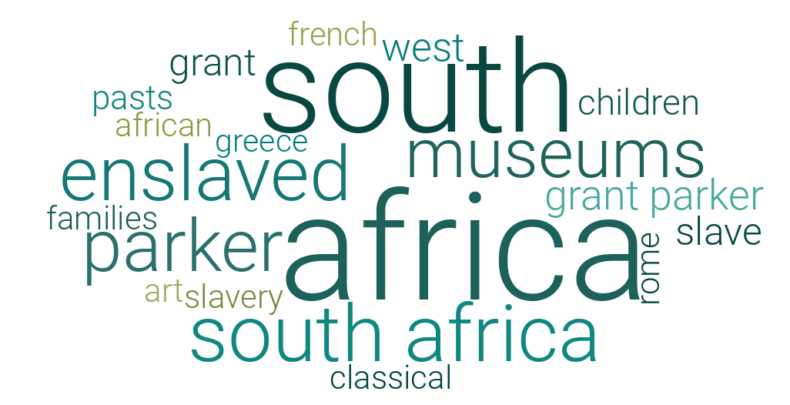

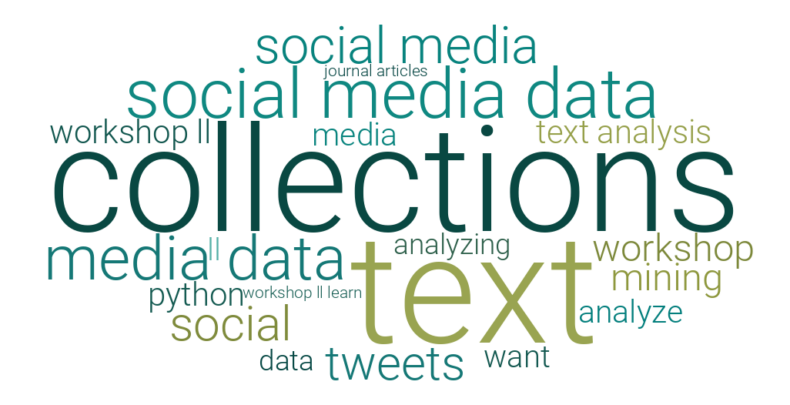

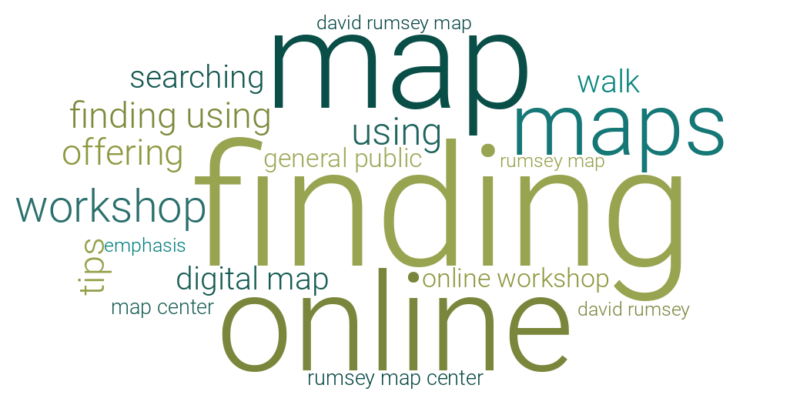

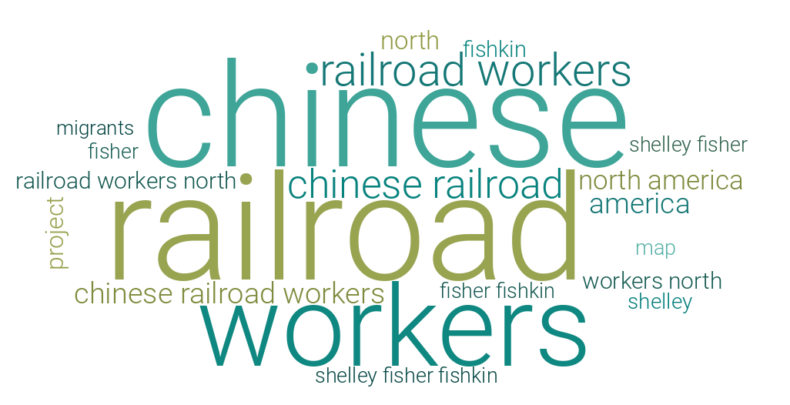

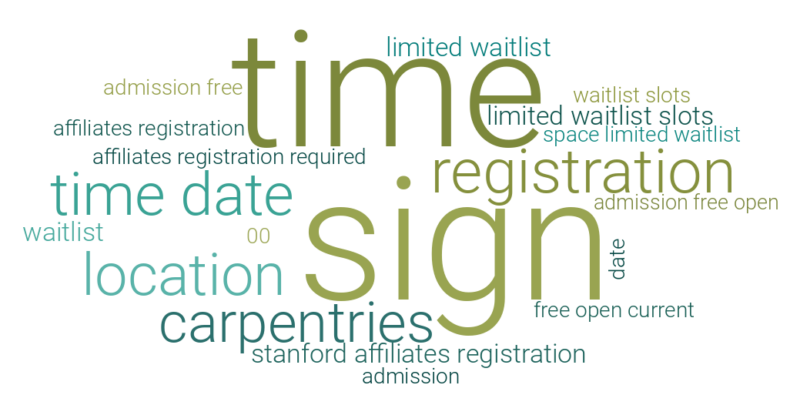

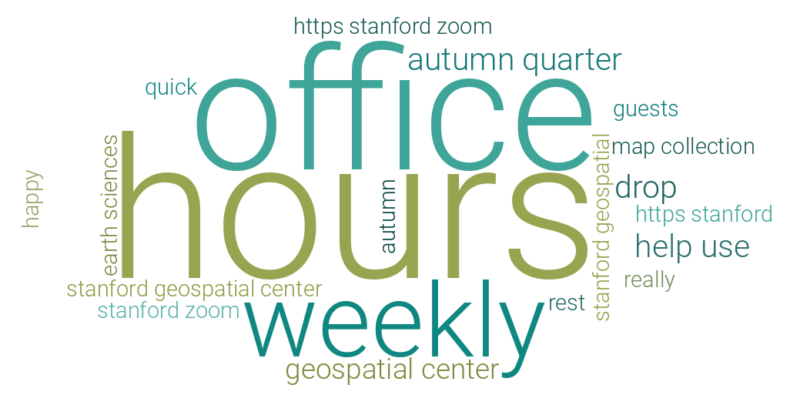

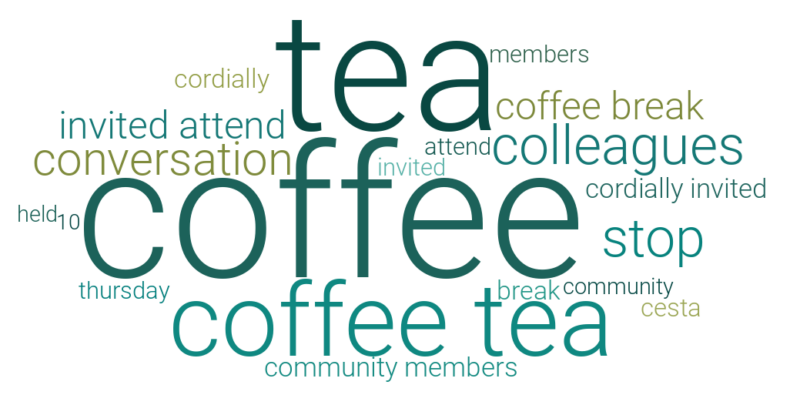

In [82]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, get_single_color_func
import os
from matplotlib.colors import LinearSegmentedColormap

# Custom Color Maps based on your provided color palette
colors = ["#7A863B", "#8F993E", "#A6B168", "#014240", "#175E54", "#2D716F", "#017E7C", "#279989", "#59B3A9"]
custom_color_map = LinearSegmentedColormap.from_list("custom_palette", colors)

# Specify the directory to save wordcloud images
wordcloud_directory = os.getcwd() + "/wordclouds"
os.makedirs(wordcloud_directory, exist_ok=True)

# Retrieve topics and their sizes
topics = topic_model.get_topics()

# Generate a word cloud for each topic
for topic_id, topic_words in topics.items():
    # if topic_id == -1:  # Skip the outlier topic if present
    #     continue

    word_scores = dict(topic_words)

    wordcloud = WordCloud(
        width=width, height=height,
        max_words=200,  # Increase number of words
        mask=mask,  # Apply the mask
        random_state=21,
        background_color='white',
        colormap=custom_color_map,
        font_path='Roboto/Roboto-Light.ttf'  # Ensure this path is correct
    ).generate_from_frequencies(word_scores)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    # Save each word cloud image to the specified directory
    plt.savefig(os.path.join(wordcloud_directory, f'wordcloud_topic_{topic_id}.png'))